<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/Copy_of_lab_vae_todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Your first VAE**
======
*Notebook created in PyTorch by [Mariona Carós](https://es.linkedin.com/in/mariona-c-a7bb91105) for the [UPC School](https://www.talent.upc.edu/ing/) (2021)*

Minor contributions by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) during 2022.

In this colab, you're going to create your first Variational Autoencoder (VAE). Specifically, you will build and train a VAE that can generate hand-written images of digits (0-9). You will be using PyTorch, so if you need to check any function you're not familiar with, you may find the [PyTorch documentation](https://https://pytorch.org/docs/stable/index.html) useful.


### **Variational Autoencoder (VAE)**
A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.
Just as a standard autoencoder, a variational autoencoder is an architecture composed of both an encoder and a decoder that is trained to minimise the reconstruction error between the encoded-decoded data and the initial data. However, in order to introduce some regularisation of the latent space, we proceed to a slight modification of the encoding-decoding process: instead of encoding an input as a single point, we encode it as a distribution over the latent space. You can checkdetails in the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf).

### **Getting Started**

You will begin by importing some useful packages and the dataset you will use to build and train your VAE. Don't forget to set GPU as your hardware accelerator in  `Runtime > Change runtime type > Hardware Accelerator`


In [ ]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils
import torch.nn.functional as F
import torchvision.transforms as transforms

from typing import Tuple
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [ ]:
# we select to work on GPU if it is available in the machine, otherwise will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [ ]:
hparams = {
    'batch_size':128,
    'num_epochs':30,
    'channels':64,
    'latent_dims':2,
    'variational_beta':1,
    'learning_rate':1e-3,
    'weight_decay':1e-5
}

**Defining the Pytorch Dataset and the DataLoader**

We will be using the MNIST dataset, which contains 60,000 images of handwritten digits, from 0 to 9. These images are in black-and-white so only **one dimension, or "color channel", is needed to represent them**.

Next, you will load the MNIST dataset as tensors using a dataloader. We create both a training set and a test set.

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
])


# Dataset initializations

mnist_trainset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms
)

mnist_testset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms
)

# Dataloders initialization

train_dataloader = torch.utils.data.DataLoader(
    dataset=mnist_trainset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=mnist_testset,
    batch_size=hparams['batch_size'],
    shuffle=False,
    drop_last=True,
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]





## 1.VAE Definition
You will use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but the total number of features still decreases, since **the channels increase by a factor of 2 in each convolution**, but the spatial size decreases by a factor of 4 as we will be using a **kernel size of 4**.

You will start by creating the encoder component of the VAE. Remember that the encoder outputs the means and covariance matrices of a multivariate normal distribution.



In [ ]:
class Encoder(nn.Module):
    def __init__(
            self,
            channels: int,
            latent_dims: int,
            ) -> None:

        super(Encoder, self).__init__()

        self.c = channels
        # TODO: Complete with the appropriate dimensions.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1) # out: 2 x c x 7 x 7
        self.fc_mu = nn.Linear(in_features=self.c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=self.c*2*7*7, out_features=latent_dims)

    def forward(self, x: torch.Tensor)-> Tuple[torch.Tensor, torch.Tensor]:

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors

        # TODO: Obtain the mean and covariance matrices from the output of the linear layers
        x_mu = self.fc_mu(out)
        x_logvar = self.fc_logvar(out)

        return x_mu, x_logvar

The next component we need to build is the decoder.

The decoder is another neural net. Its **input is the representation z** and it **outputs the parameters to the probability distribution** of the data.


*Hint*:  
You are encouraged to use these functions in *forward()*:
```
Convolutional layers:
self.conv1()
self.conv2()

Activation functions:
F.relu()
torch.sigmoid()
```


In [ ]:
class Decoder(nn.Module):
    def __init__(
            self,
            channels: int,
            latent_dims: int
            ) -> None:

        super(Decoder, self).__init__()
        self.c = channels
        # TODO
        self.fc = nn.Linear(in_features=latent_dims, out_features=self.c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:

        out = self.fc(z)
        out = out.view(out.size(0), self.c*2, 7, 7) # unflatten batch

        # TODO
        out = F.relu(self.conv2(out))
        out = torch.sigmoid(self.conv1(out))
        return out

The overall architecture is then obtained by concatenating the encoder and the decoder parts. However we still need to be very careful about the way we sample from the distribution returned by the encoder during the training. The sampling process has to be expressed in a way that allows the error to be backpropagated through the network. So, the steps you'll take are:

1.   Real image input to encoder
2.   Encoder outputs mean and standard deviation
3.   Sample from distribution with the outputed mean and standard deviation (Reparametrization trick)
4.   Take sampled value as the input to the decoder
5.   Get fake sample
6.   Use reconstruction loss between the fake output of the decoder and the original real input to the encoder (more about this later - keep reading!)
7.   Backpropagate through

A simple trick, called reparametrisation trick, is used to make the gradient descent possible despite the random sampling that occurs halfway of the architecture and consists in using the fact that if z is a random variable following a Gaussian distribution with mean $\mu$ and with covariance $\Sigma$ then it can be expressed as:
$$z=\Sigma \epsilon + \mu$$   $$\epsilon \sim N(0,I)$$

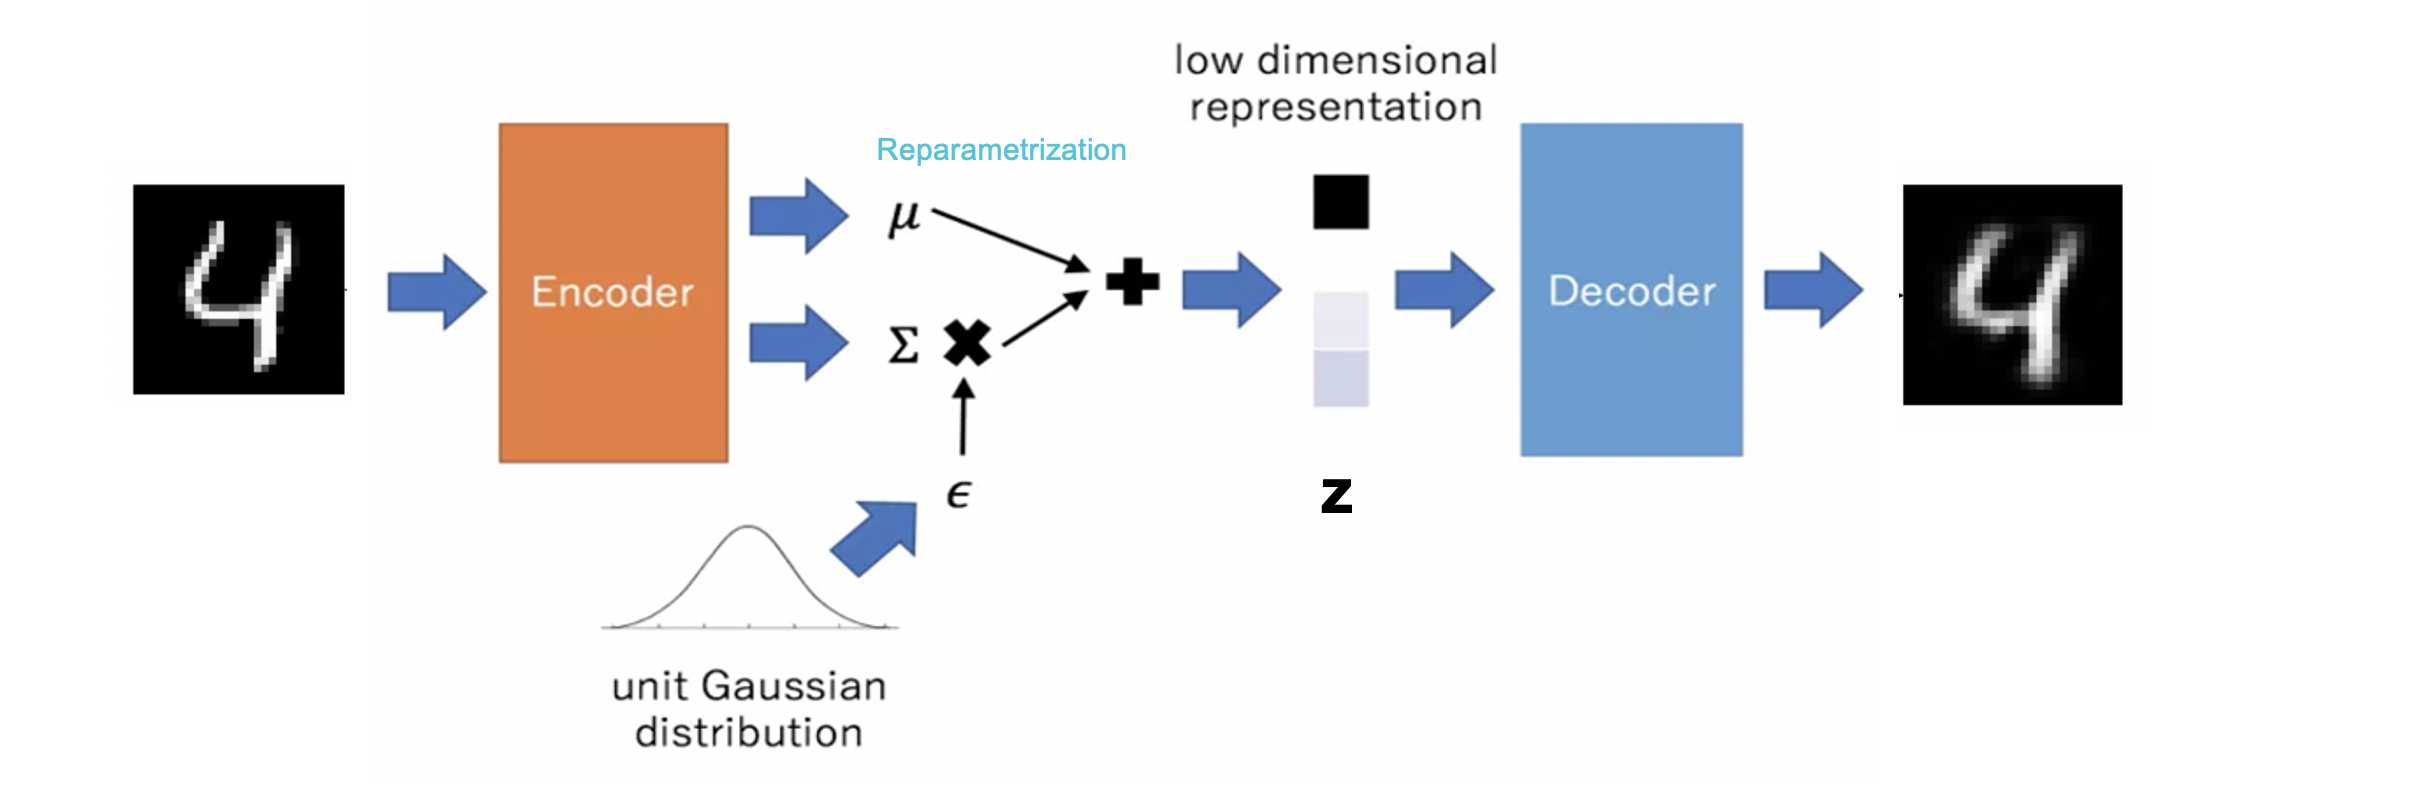


In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(
            self,
            z_dims: int,
            n_ch: int,
            ) -> None:

        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(channels=n_ch,latent_dims=z_dims)
        self.decoder = Decoder(channels=n_ch, latent_dims=z_dims)

    def reparametrize(
            self,
            mu:torch.Tensor,
            logvar:torch.Tensor,
            ) -> torch.Tensor:
        # Given mean and logvar returns z
        # reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,I)
        # mu, logvar: mean and log of variance of Q(z|X)

        # The factor 1/2 in the exponent ensures that the distribution has unit variance
        std = torch.exp(0.5 * logvar)
        # Random sample
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x: torch.Tensor) -> Tuple[
            torch.Tensor, torch.Tensor, torch.Tensor]:
        # TODO
        latent_mu, latent_logvar = self.encoder(x)
        z = self.reparametrize(latent_mu, latent_logvar)
        x_recon = self.decoder(z)

        return x_recon, latent_mu, latent_logvar

The loss function that is minimised when training a VAE is composed of a “reconstruction term” (on the final layer), that tends to make the encoding-decoding scheme as performant as possible, and a “regularisation term” (on the latent layer), that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution.

The mathematical notation for the lower bound you want to maximize would be: $\mathbb{E}\left(\log p(x|z)\right) + \mathbb{E}\left(\log \frac{p(z)}{q(z)}\right)$, which is equivalent to $\mathbb{E}\left(\log p(x|z)\right) - \mathrm{D_{KL}}(q(z|x)\Vert p(z))$

**Reconstruction loss**

Reconstruction loss refers to the distance between the real input image (that you put into the encoder) and the generated image (that comes out of the decoder). Explicitly, the reconstruction loss term is $\mathbb{E}\left(\log p(x|z)\right)$, the log probability of the true image given the latent value.

The recontruction loss is our choice, here we have treat each grayscale prediction as a binary random variable (also known as a Bernoulli distribution) with the value between 0 and 1 of a pixel corresponding to the output brightness, so you can use the binary cross entropy loss between the real input image and the generated image in order to represent the reconstruction loss term:

`F.binary_cross_entropy(input, target, reduction='sum')`

**KL Divergence**

KL divergence allows you to evaluate how different one probability distribution is from another. If you have two distributions and they are exactly the same, then KL divergence is equal to 0. KL divergence is close to the notion of distance between distributions, but notice that it's called a divergence, not a distance; this is because it is not symmetric, meaning that $\mathrm{KL}(p\Vert q)$ is usually not equal to the terms flipped $\mathrm{KL}(q\Vert p)$.

If both of your distributions are normal distributions, you can calculate the KL divergence, or $\mathrm{D_{KL}}(q(z|x)\Vert p(z))$, based on a simple formula:

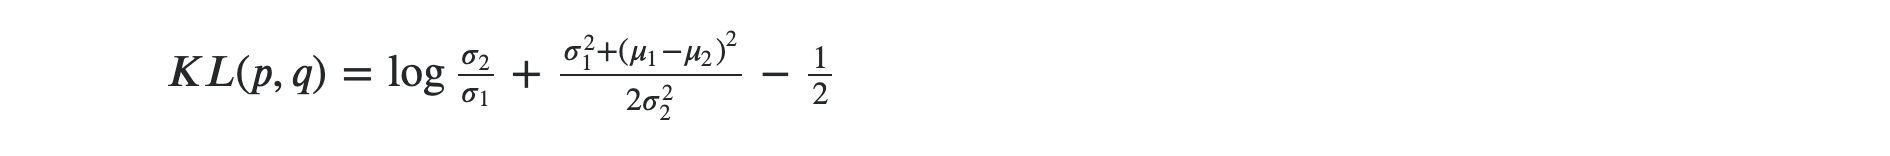

This makes KL divergence an attractive measure to use and the normal distribution a simultaneously attractive distribution to assume on your model and data!

<!-- Well, your encoder is learning $q(z|x)$, but what's your latent prior $p(z)$? It is actually a fairly simple distribution for the latent space with a mean of zero and a standard deviation of one in each dimension, or $\mathcal{N}(0, I)$. You might also come across this as the spherical normal distribution, where the $I$ in $\mathcal{N}(0, I)$ stands for the identity matrix, meaning its covariance is 1 along the entire diagonal of the matrix and if you like geometry, it forms a nice symmetric-looking hypersphere, or a sphere with many (here, $z$) dimensions. -->




## 2.Define Loss Function

In [ ]:
def vae_loss(
        recon_x: torch.Tensor,
        x: torch.Tensor,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        variational_beta: int=1,
        ) -> float:
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = variational_beta * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    mean_batch_loss = (recon_loss +  kldivergence)/x.shape[0]

    return mean_batch_loss

## 3.Training

It's time to train your model. You can initialize your model and the optimizer by calling: ` VariationalAutoencoder(z_dims, n_ch)` and `torch.optim.Adam(params=..., lr=..., weight_decay=...)`. Parameters of the model are given by  `vae.parameters()`


Then, call ` vae_2z(x)` and `vae_loss(recon_x, x, mu, logvar)` functions to run the training loop and observe the training process!

If there is an error in the code, you will have to check previous sections :(

In [ ]:
def train_batch(
        image_batch: torch.Tensor,
        vae: torch.nn.Module,
        vae_loss: torch.nn.Module,
        optimizer: torch.optim,
        ) -> float:

    image_batch = image_batch.to(device)

    # TODO: Get vae reconstruction and loss
    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
    loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar, hparams['variational_beta'])

    # backpropagation
    optimizer.zero_grad()
    loss.backward()

    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()

    return loss.item()

### Train loop

In [ ]:
start_time=time.time()

# TODO: Instantiate optimizer and model here
vae_2z = VariationalAutoencoder(hparams['latent_dims'], hparams['channels']).to(device)
optimizer = torch.optim.Adam(params=vae_2z.parameters(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])

# This is the number of parameters used in the model
num_params = sum(p.numel() for p in vae_2z.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

# set to training mode
vae_2z.train()

train_loss_avg = []

print('Training ...')
for epoch in range(hparams['num_epochs']):
    train_loss_avg.append(0)
    num_batches = 0

    for i,(image_batch,_) in enumerate(train_dataloader):

        loss_batch = train_batch(image_batch, vae_2z, vae_loss, optimizer)
        train_loss_avg[-1] += loss_batch

    train_loss_avg[-1] /= i
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, hparams['num_epochs'], train_loss_avg[-1]))

print("--- TOTAL TIME: %s min ---" % (round((time.time() - start_time) / 60, 3)))

Number of parameters: 308357
Training ...
Epoch [1 / 30] average reconstruction error: 184.943064
Epoch [2 / 30] average reconstruction error: 164.679943
Epoch [3 / 30] average reconstruction error: 160.551573
Epoch [4 / 30] average reconstruction error: 158.346548
Epoch [5 / 30] average reconstruction error: 156.925285
Epoch [6 / 30] average reconstruction error: 155.795451
Epoch [7 / 30] average reconstruction error: 155.018699
Epoch [8 / 30] average reconstruction error: 154.305568
Epoch [9 / 30] average reconstruction error: 153.764009
Epoch [10 / 30] average reconstruction error: 153.262039
Epoch [11 / 30] average reconstruction error: 152.790690
Epoch [12 / 30] average reconstruction error: 152.488522
Epoch [13 / 30] average reconstruction error: 152.113712
Epoch [14 / 30] average reconstruction error: 151.843568
Epoch [15 / 30] average reconstruction error: 151.548604
Epoch [16 / 30] average reconstruction error: 151.293465
Epoch [17 / 30] average reconstruction error: 151.03755

#### Plot Training Curve
Run the code to check how the training loss changes with every iteration over the dataset. If it decreases, it's a sign that your model is learning!

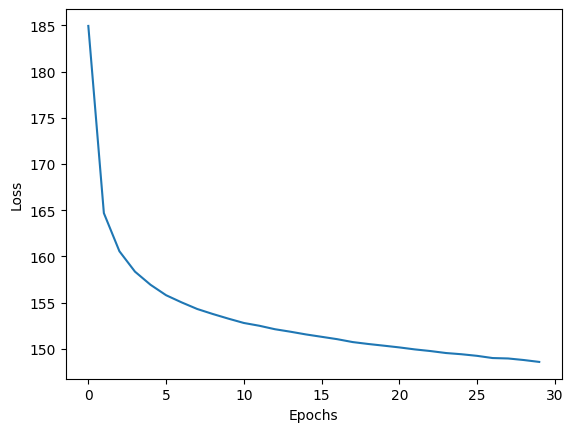

In [ ]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluate on the Test Set

In [ ]:
# set to evaluation mode
vae_2z.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae_2z(image_batch)
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar, hparams['variational_beta'])

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 151.732988


## 4.Visualize Generated Images and Latent Space
In this section you'll be able to see the performance of your VAE and play with its latent space.

Run the code to compare the original images vs the reconstructed ones by your model from the gaussian latent space.

In [ ]:
# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x: torch.Tensor) -> torch.Tensor:
    x = x.clamp(0, 1)
    return x

def show_image(img: torch.Tensor) -> None:
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

@torch.no_grad()
def visualise_output(
        images: torch.Tensor,
        model: nn.Module,
        device: torch.device,
        ) -> None:
    images = images.to(device)
    model.to(device)
    images, _, _ = model(images)
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

Original images


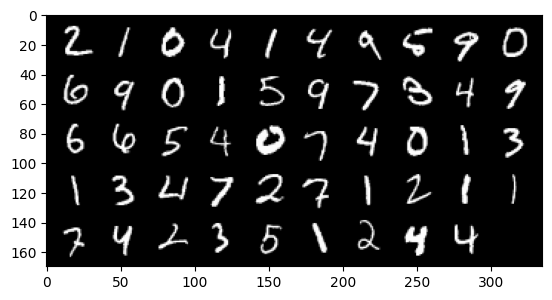

VAE reconstruction:


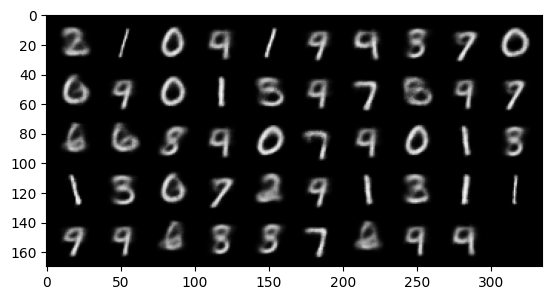

In [ ]:
vae_2z.eval()
images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_2z, device)

Once you know your VAE is working, you can save it by using the following line of code:

In [ ]:
# this is how the VAE parameters can be saved:
torch.save(vae_2z.state_dict(), './my_vae_2z.pth')

Now we're going to **load a pre-trained VAE with latent_dims=10** and compare the reconstructions with the previous ones.
Will there be any difference?

### Load Pre-Trained VAE


In [ ]:
# Download model
!wget https://github.com/telecombcn-dl/labs-all/raw/main/labs/vae/vae_10d.pth

--2026-02-11 16:44:09--  https://github.com/telecombcn-dl/labs-all/raw/main/labs/vae/vae_10d.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/telecombcn-dl/labs-all/main/labs/vae/vae_10d.pth [following]
--2026-02-11 16:44:10--  https://raw.githubusercontent.com/telecombcn-dl/labs-all/main/labs/vae/vae_10d.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1839867 (1.8M) [application/octet-stream]
Saving to: ‘vae_10d.pth’

vae_10d.pth         100%[===================>]   1.75M  --.-KB/s    in 0.06s   

2026-02-11 16:44:10 (31.4 MB/s) - ‘vae_10d.pth’ saved [1839867/1839867]



In [ ]:
# Load checkpoint
checkpoint=torch.load('vae_10d.pth', map_location=torch.device('cpu'))

vae_10z = VariationalAutoencoder(z_dims = 10, n_ch = 64)
vae_10z.load_state_dict(checkpoint)
print('model loaded')

model loaded


Original images


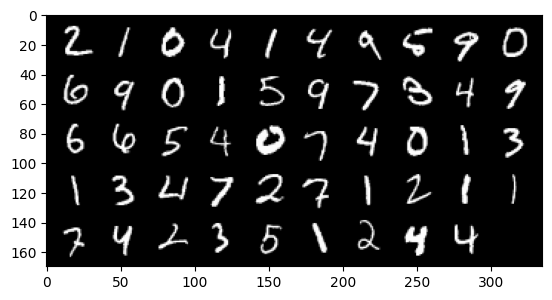

VAE reconstruction:


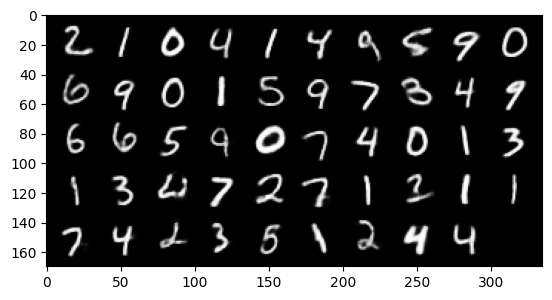

In [ ]:
vae_10z.eval()
images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_10z, 'cpu')

### Interpolate in Latent Space

Let's play a little bit with the latent space by generating the interpolation between 2 numbers! Replace `...` by any numbers you want.



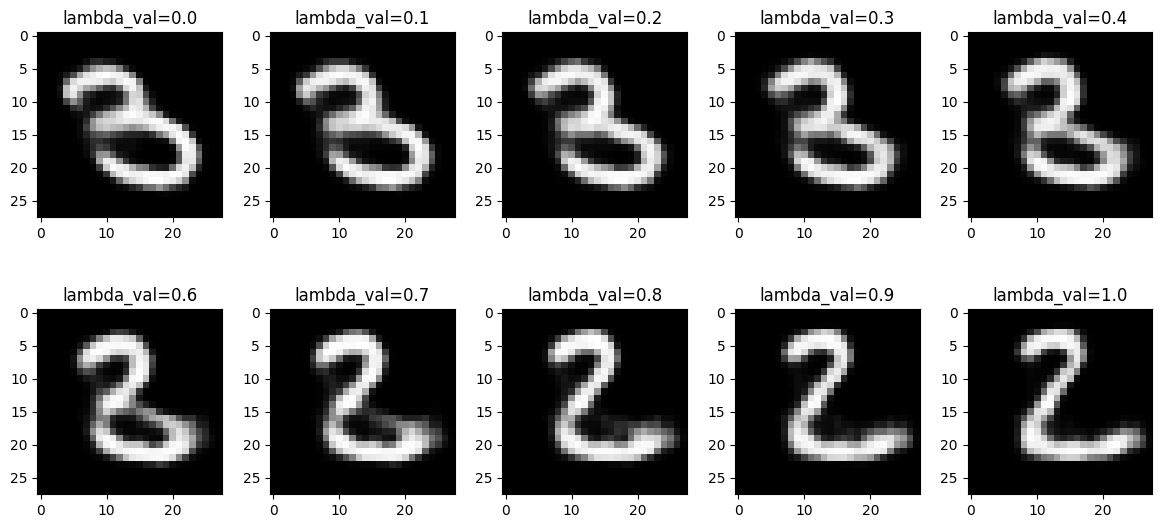

In [ ]:
vae_10z.eval()
vae_10z.to(device)

def interpolation(
        lambda1: float,
        model: nn.Module,
        img2: torch.Tensor,
        img1: torch.Tensor,
        ) -> torch.Tensor:

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):

    # TODO
    inter_image=interpolation(float(l), vae_10z, digits[3][0], digits[2][0])

    inter_image = to_img(inter_image)
    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

### VAE as Generator - Sample Latent Vector from Prior

As you know, a VAE can generate new digits by drawing latent vectors from the prior distribution. Let's create a random tensor from a normal distribution by using `torch.randn(size, latent_dims, device='cuda)` and pass the tensor through the decoder to obtain generated numbers! Set `size` with the number of samples you want to generate. You can use either the model you have trained with a latent space of 2 dimensions or the loaded model with z=10.


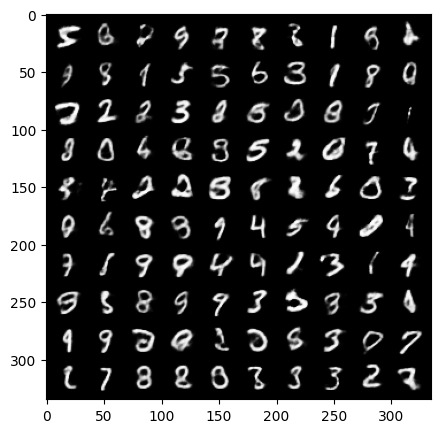

In [ ]:
with torch.no_grad():

    # TODO: Sample latent vectors from the normal distribution
    # and reconstruct images from the latent vectors
    latent = torch.randn(100, 10, device=device)
    img_recon = vae_10z.decoder(latent)

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.cpu().data[:100],10,5))
    plt.show()

### Visualize Latent Space

To visualize the latent space, you'll need to use the VAE you have trained with 2 latent dimensions which should be stored in `vae_2z`.


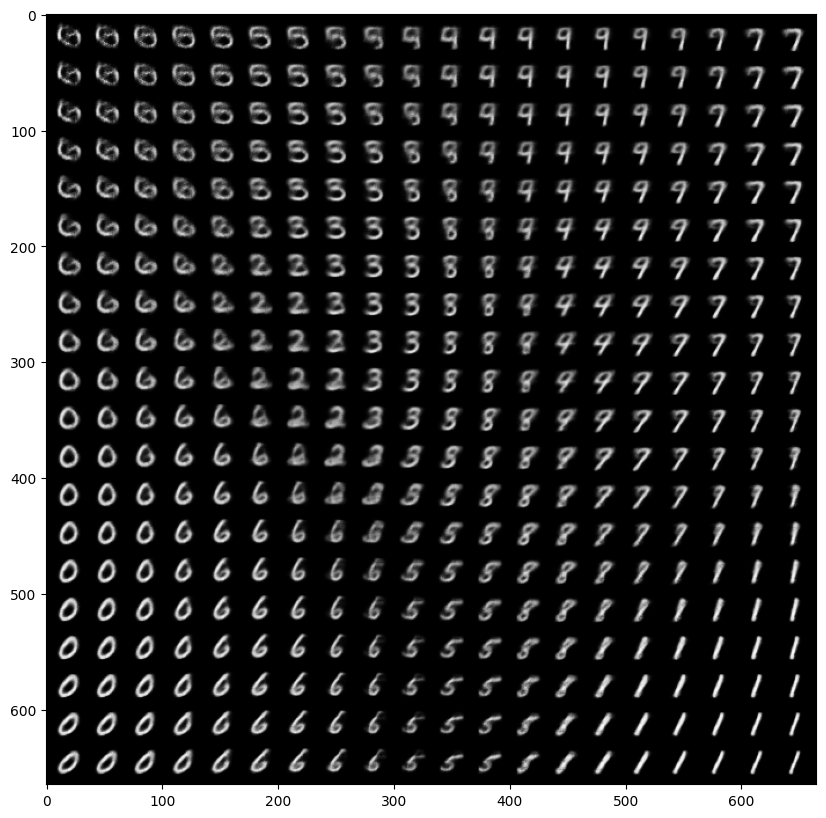

In [ ]:
with torch.no_grad():
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch
    latents = latents.to(device)
    vae_2z.to(device)

    #TODO: reconstruct images from the latent vectors
    image_recon = vae_2z.decoder(latents)

    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()